In [2]:
%pip install -qU torch transformers polars

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 44.7 MB/s eta 0:00:00


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from pathlib import Path
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch import Tensor
from tqdm import tqdm, trange
import pickle
from transformers import AutoTokenizer, AutoModel

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Load data

In [6]:
ch_descr_path = Path("/content/drive/MyDrive/Telegram Marketing/Embeddings/channels/channels_data_for_emb.csv")
ch_descr = pl.read_csv(ch_descr_path)
ch_descr.drop_in_place("last_pinned_msg_id")
ch_descr

id,title,about
i64,str,str
1097289882,"""Medical Ксю""","""Канал о цифровых технологиях в…"
1203719412,"""Design Porn""",""""""
1336205252,"""Tolmaç Channel""","""Group of @TolmacBot Chat @tolm…"
1906656409,"""Gaimin Gladiators""",""""""
1785605454,"""Антон Архипов | Про инфобиз""","""Про проекты и работу команды. …"
…,…,…
1667226149,"""🐈Calico Cat🐈‍⬛""","""Мяукаю"""
2223746475,"""аушня от малого❄⛄""","""🦔🍂🦔 анон - @navimmilBot с вонк…"
1447537721,"""Sun above my head|| Кеметизм""","""+18, рекламы нет Под солнцем в…"


In [7]:
pinned_posts_path = Path("/content/drive/MyDrive/Telegram Marketing/Embeddings/channels/pinned_raw_texts.pkl")
with open(pinned_posts_path, "rb") as f:
    pinned_posts = pickle.load(f)
len(pinned_posts)

17938

In [11]:
for ch_id, pinned_text in pinned_posts.items():
    print(f"{ch_id}\n=====\n{pinned_text}")
    break

1562463823
=====
Мы объединили ChatGPT и Midjourney прямо в телеграме в виде бота — @chatgpt

Бот бесплатный без смс, впн и регистраций, пользуйтесь: запустить бот


## Construct text for embeddings

In [13]:
stats = {"title": len(ch_descr), "about": 0, "pinned": 0}  # Calc stats also
documents = []

for ch_id, title, about in tqdm(ch_descr.iter_rows()):
    pinned_text = pinned_posts.get(ch_id, None)

    doc = f"Название: {title}"
    if about:
        stats["about"] += 1
        doc += f"\nОписание: {about}"
    if pinned_text:
        stats["pinned"] += 1
        doc += f"\nЗакрепленный пост: {pinned_text}"

    documents.append(doc)

26782it [00:00, 167385.91it/s]


In [17]:
# Analyze stats
print(f"""channels = {stats['title']}, 100%
about texts = {stats['about']}, {stats['about']/stats['title']*100}% of channels
pinned texts = {stats['pinned']}, {stats['pinned']/stats['title']*100}% of channels""")

channels = 26782, 100%
about texts = 25343, 94.62698827570757% of channels
pinned texts = 17322, 64.67776865058622% of channels


In [14]:
print(documents[1489])

Название: aesculab
Описание: Канал-коллаборация двух друзей: акушера-гинеколога и педиатра из передовых федеральных центров нашей необъятной 

Педиатр Курант Мария Сергеевна

Акушер-гинеколог Гридякин Иван Владимирович

Медицина- это искусство
Закрепленный пост: Прекрасного вам дня, друзья! ☀️
Мы рады видеть всех присоединившихся к нам!😍

Для удобства, собрали вам список самых полезных постов:

🟠 Кто мы и откуда
🟠 Расширенный неонатальный скрининг
🟠 Ординатура Марии в НМИЦ Здоровья детей
🟠 Ординатура Ивана в НМИЦ АГП им. Кулакова
🟠 Как считаются дни в роддоме?
🟠 Спинальная мышечная атрофия I типа
🟠 Послеродовое отделение
🟠 Золгенсма - лечение СМА I типа
🟠 Генозаместительная терапия 
🟠 Оценка новорожденного по шкале Апгар
🟠 Выставка «Россия» и её павильон Атом
🟠 Как рожали 200 лет назад?
🟠 Плакаты первой помощи XIX века 
🟠 Самые дорогие в мире препараты
🟠 Выставка «Россия» и её стенд Акушерство
🟠 Беременность и роды
🟠 Свод полезной информации, касаемой развития иммунной системы (3 части

In [18]:
def get_detailed_instruct(task_description: str, query: str) -> str:
    return f'Задача: {task_description}\nДанные: {query}'

In [21]:
task = "Проанализировав данные Telegram-канала (название, описание, закрепленный пост), опиши его типичный профиль (тематика, аудитория, тон общения)"

input_texts = []
for doc in tqdm(documents):
    input_texts.append(get_detailed_instruct(task, doc))

100%|██████████| 26782/26782 [00:00<00:00, 224900.29it/s]


In [22]:
print(input_texts[1489])

Задача: Проанализировав данные Telegram-канала (название, описание, закрепленный пост), опиши его типичный профиль (тематика, аудитория, тон общения)
Данные: Название: aesculab
Описание: Канал-коллаборация двух друзей: акушера-гинеколога и педиатра из передовых федеральных центров нашей необъятной 

Педиатр Курант Мария Сергеевна

Акушер-гинеколог Гридякин Иван Владимирович

Медицина- это искусство
Закрепленный пост: Прекрасного вам дня, друзья! ☀️
Мы рады видеть всех присоединившихся к нам!😍

Для удобства, собрали вам список самых полезных постов:

🟠 Кто мы и откуда
🟠 Расширенный неонатальный скрининг
🟠 Ординатура Марии в НМИЦ Здоровья детей
🟠 Ординатура Ивана в НМИЦ АГП им. Кулакова
🟠 Как считаются дни в роддоме?
🟠 Спинальная мышечная атрофия I типа
🟠 Послеродовое отделение
🟠 Золгенсма - лечение СМА I типа
🟠 Генозаместительная терапия 
🟠 Оценка новорожденного по шкале Апгар
🟠 Выставка «Россия» и её павильон Атом
🟠 Как рожали 200 лет назад?
🟠 Плакаты первой помощи XIX века 
🟠 Самые до

## Analyze length

In [23]:
pl.DataFrame([len(i) for i in input_texts]).describe()

statistic,column_0
str,f64
"""count""",26782.0
"""null_count""",0.0
"""mean""",873.570868
"""std""",744.768496
"""min""",169.0
"""25%""",346.0
"""50%""",592.0
"""75%""",1178.0
"""max""",4587.0


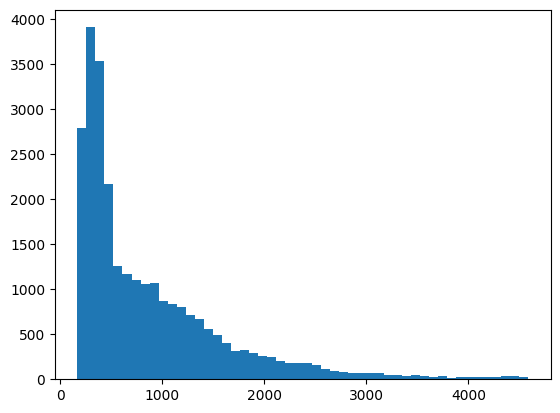

In [24]:
plt.hist([len(i) for i in input_texts], bins=50);

In [34]:
# Analyze tokenized length
model_name = 'intfloat/multilingual-e5-large-instruct'
tokenizer = AutoTokenizer.from_pretrained(model_name)

tok_length = []
for inp in tqdm(input_texts):
    tokens = tokenizer(inp, padding=False, truncation=False, return_tensors="np", verbose=True)['input_ids']
    tok_length.append(tokens.shape[1])

100%|██████████| 26782/26782 [01:00<00:00, 442.96it/s]


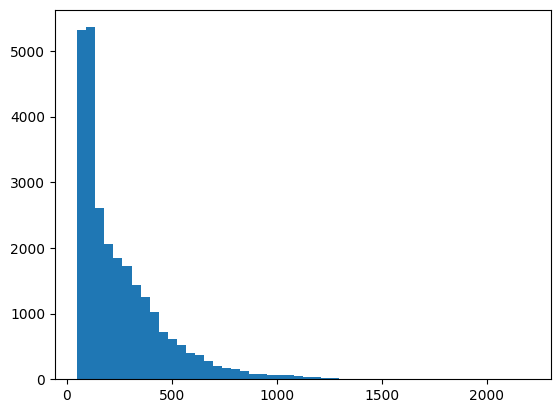

In [36]:
plt.hist(tok_length, bins=50);

In [38]:
pl.DataFrame(tok_length).describe()

statistic,column_0
str,f64
"""count""",26782.0
"""null_count""",0.0
"""mean""",255.775894
"""std""",212.665352
"""min""",51.0
"""25%""",104.0
"""50%""",182.0
"""75%""",342.0
"""max""",2197.0


In [39]:
len([l for l in tok_length if l > 514]) / len(tok_length) * 100

10.940183705473826

Почти 11% описаний каналов будут обрезано, но думаю это не критично, так как в любом случае будет обрезаться часть которая приходиться на текст закрепленного поста (и кажется что основная информация в основном в начале)

## Calc embeddings

In [40]:
model_name = 'intfloat/multilingual-e5-large-instruct'

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
model = model.to(device)

config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

In [42]:
def average_pool(last_hidden_states: Tensor,
                 attention_mask: Tensor) -> Tensor:
    last_hidden = last_hidden_states.masked_fill(~attention_mask[..., None].bool(), 0.0)
    return last_hidden.sum(dim=1) / attention_mask.sum(dim=1)[..., None]


def process_in_batches(model, tokenizer, input_texts, batch_size=16, device=torch.device("cpu")):
    embeddings = []
    for i in trange(0, len(input_texts), batch_size):
        batch_texts = input_texts[i:i + batch_size]

        batch_dict = tokenizer(batch_texts, max_length=512, padding=True, truncation=True, return_tensors='pt')
        batch_dict = {k: v.to(device) for k, v in batch_dict.items()}

        with torch.no_grad():
            outputs = model(**batch_dict)
            batch_embeddings = average_pool(outputs.last_hidden_state, batch_dict['attention_mask'])

        batch_embeddings = F.normalize(batch_embeddings, p=2, dim=1)
        embeddings.append(batch_embeddings.cpu())

        del batch_dict, outputs, batch_embeddings
        torch.cuda.empty_cache()


    return torch.cat(embeddings, dim=0)


In [46]:
embeddings = process_in_batches(model, tokenizer, input_texts, batch_size=16, device=device)
embeddings.shape

100%|██████████| 1674/1674 [38:01<00:00,  1.36s/it]


torch.Size([26782, 1024])

In [47]:
# Save embeddings
EMB_FILE = Path("/content/drive/MyDrive/Telegram Marketing/Embeddings/channels/ch_emb_wo_posts_e5_instruct.npy")
np.save(EMB_FILE, embeddings.numpy())

# Also save indices of posts
IDS_FILE = Path("/content/drive/MyDrive/Telegram Marketing/Embeddings/channels/ids_ch_emb_wo_posts_e5_instruct.npy")
np.save(IDS_FILE, ch_descr["id"].to_numpy())

In [48]:
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   2143 MiB |   2736 MiB |  22736 GiB |  22733 GiB |
|       from large pool |   2142 MiB |   2734 MiB |  22492 GiB |  22490 GiB |
|       from small pool |      1 MiB |      2 MiB |    243 GiB |    243 GiB |
|---------------------------------------------------------------------------|
| Active memory         |   2143 MiB |   2736 MiB |  22736 GiB |  22733 GiB |
|       from large pool |   2142 MiB |   2734 MiB |  22492 GiB |